<a href="https://colab.research.google.com/github/SinghVans/GNN690/blob/main/COSC690Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COSC 690 - GNN vs CNN Code: 
Matt Lane 
Vanshika Singh

In [2]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 1.7MB/s 
     |████████████████████████████████| 1.5MB 2.0MB/s 
     |████████████████████████████████| 194kB 4.2MB/s 
     |████████████████████████████████| 235kB 7.2MB/s 
     |████████████████████████████████| 2.2MB 8.0MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 


In [7]:
import torch
import scipy
from torch_geometric.datasets import TUDataset
from torch_geometric import utils
from torch_geometric.data import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

import networkx as nx
import numpy as np

from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from matplotlib import pyplot
import matplotlib.gridspec as gridspec

from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split


def load_pytorchDataset(datasetName): 
  dataset = TUDataset(root='data/TUDataset', name=datasetName)

  print()
  print(f'Dataset: {dataset}:')
  print('====================')
  print(f'Number of graphs: {len(dataset)}')
  print(f'Number of features: {dataset.num_features}')
  print(f'Number of classes: {dataset.num_classes}')

  data = dataset[0]  # Get the first graph object.

  print()
  print(data)
  print('=============================================================')

  # Gather some statistics about the first graph.
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
  print(f'Contains self-loops: {data.contains_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')

  return dataset

## Loading Data from the TU Dataset

In [8]:
dataset = load_pytorchDataset('MUTAG')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Visualizing The Data

tensor([1])
tensor([0])


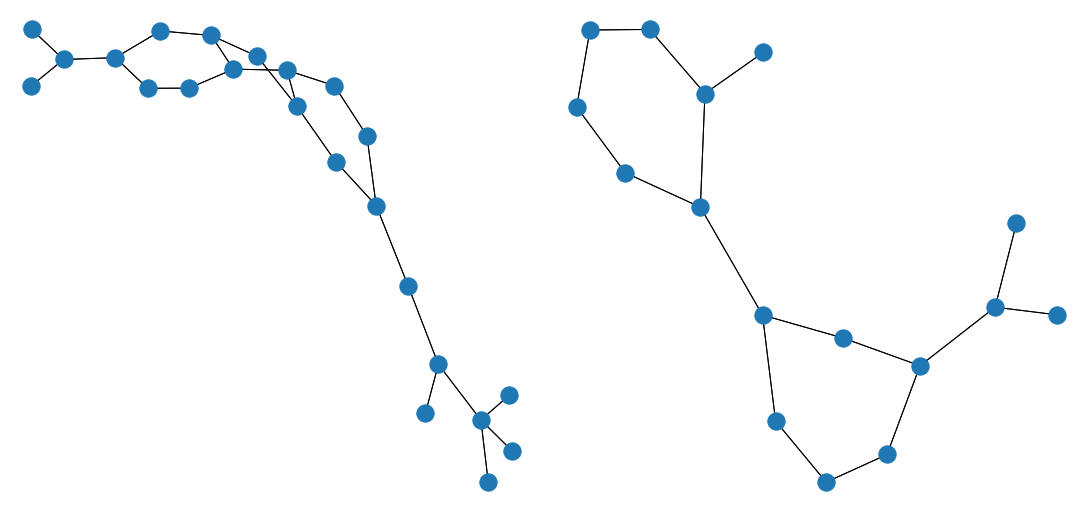

In [60]:
def drawElement(dataset, element): 
  G = utils.to_networkx(dataset[element])
  adj = nx.adjacency_matrix(G)
  arradjacency = adj.toarray()
  print(dataset[element].y)
  # pos = nx.planar_layout(G)

  nx.draw(G,label=True, arrows=False)

def visualizeGraphsFromDataset(dataset, element1=32, element2=76): 
  fig2 = plt.figure(constrained_layout=True, figsize=(15,7))
  spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)
  f2_ax1 = fig2.add_subplot(spec2[0, 0])
  drawElement(dataset, element1)

  f2_ax2 = fig2.add_subplot(spec2[0, 1])
  drawElement(dataset, element2)

visualizeGraphsFromDataset(dataset)

In [24]:
## Requires making a padding list. Easier to automate - see func below :D 
def convertGraphsToAdjacencyMatrices(dataset, paddingVals, introduceIsopmorphs=False):
  outputListLength = len(dataset) if not introduceIsopmorphs else len(dataset)*2

  matrixList = np.empty((outputListLength,28,28))
  groundTruth = np.empty(outputListLength, dtype=int)

  outputIndex = 0

  for index in range(len(dataset)): 
    graph = utils.to_networkx(dataset[index])
    adj = nx.adjacency_matrix(graph)
    arradjacency = adj.toarray()

    numNodes = dataset[index].num_nodes
    paddedArray = np.pad(arradjacency, paddingVals[f"{numNodes}"]) 
    fittedPadding = paddedArray if numNodes % 2 == 0 else np.delete(np.delete(paddedArray, -1, axis= 0), -1, axis=1)

    matrixList[outputIndex] = fittedPadding
    # print(dataset[index].y)
    groundTruth[outputIndex] = dataset[index].y
    outputIndex +=1 

    if introduceIsopmorphs: 

      flipped = np.flip(np.flip(fittedPadding, axis=0), axis=1)
      matrixList[outputIndex] = flipped
      groundTruth[outputIndex] = dataset[index].y
      outputIndex +=1 

    # matrixList[outputIndex] = np.flip(fittedPadding)
    # groundTruth[outputIndex] = dataset[index].y
    # outputIndex +=1 

  return matrixList, groundTruth


# includes flipped matrices for more learning in CNN
# (convertedAdjMatrices, groundTruthArray) = convertGraphsToAdjacencyMatrices(dataset,paddingVals) 
# (convertedAdjMatrices_withIsomorphisms, groundTruthArray_withIsomorphisms) = convertGraphsToAdjacencyMatrices(dataset,paddingVals, True) 

In [25]:
def convertGraphsToAdjacencyMatrices_autoPad(dataset, introduceIsopmorphs=False):
  maxNodes = 0
  for graph in dataset:
    if graph.num_nodes > maxNodes: 
      maxNodes  = graph.num_nodes

  if maxNodes %2 == 1: 
    maxNodes = maxNodes + 1

  outputListLength = len(dataset) if not introduceIsopmorphs else len(dataset)*2

  matrixList = np.empty((outputListLength,maxNodes,maxNodes))
  groundTruth = np.empty(outputListLength, dtype=int)

  outputIndex = 0

  for index in range(len(dataset)): 
    graphNodeCount = dataset[index].num_nodes

    padValue = (maxNodes-graphNodeCount) - int((maxNodes-graphNodeCount)/2)

    
    graph = utils.to_networkx(dataset[index])
    adj = nx.adjacency_matrix(graph)
    arradjacency = adj.toarray()

    numNodes = dataset[index].num_nodes
    paddedArray = np.pad(arradjacency, padValue) 

    fittedPadding = paddedArray if numNodes % 2 == 0 else np.delete(np.delete(paddedArray, -1, axis= 0), -1, axis=1)

    matrixList[outputIndex] = fittedPadding
    # print(dataset[index].y)
    groundTruth[outputIndex] = dataset[index].y
    outputIndex +=1 

    if introduceIsopmorphs: 

      flipped = np.flip(np.flip(fittedPadding, axis=0), axis=1)
      matrixList[outputIndex] = flipped
      groundTruth[outputIndex] = dataset[index].y
      outputIndex +=1 

    # matrixList[outputIndex] = np.flip(fittedPadding)
    # groundTruth[outputIndex] = dataset[index].y
    # outputIndex +=1 

  return matrixList, groundTruth

In [26]:
# includes flipped matrices for more learning in CNN
(convertedAdjMatricesAP, groundTruthArrayAP) = convertGraphsToAdjacencyMatrices_autoPad(dataset) 
(convertedAdjMatrices_withIsomorphismsAP, groundTruthArray_withIsomorphismsAP) = convertGraphsToAdjacencyMatrices_autoPad(dataset, True) 

In [49]:
def visualizeIsomorphs(matrix, isomorph): 
  fig2 = plt.figure(constrained_layout=True)
  spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)
  f2_ax1 = fig2.add_subplot(spec2[0, 0])
  f2_ax2 = fig2.add_subplot(spec2[0, 1])

  f2_ax1.imshow(matrix)  
  f2_ax2.imshow(isomorph)


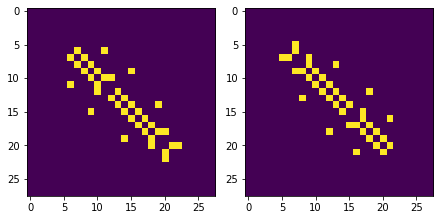

In [50]:
visualizeIsomorphs(convertedAdjMatrices_withIsomorphismsAP[0],convertedAdjMatrices_withIsomorphismsAP[1] )

### CNN Code: 

In [51]:

def load_dataset(dataset, maxNodes, includeIsomorphism=False):
	# load dataset
	(convertedAdjMatrices, groundTruthArray) = convertGraphsToAdjacencyMatrices_autoPad(dataset, includeIsomorphism) 
	trainX, testX, trainY, testY = train_test_split(convertedAdjMatrices, groundTruthArray, test_size=0.33, random_state=42)
  

	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], maxNodes, maxNodes, 1))
	testX = testX.reshape((testX.shape[0], maxNodes, maxNodes, 1))

	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# define cnn model
def define_model(maxNodes):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(maxNodes, maxNodes, 1)))
	model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(2, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluateModel(dataX, dataY, maxNodes, n_folds=5):

	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model(maxNodes)
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def graphLossAndAccuracy(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()


# run the test harness for evaluating a model
def run_test_CNN(dataset,includeIsomorphism=False):
	# load dataset
	maxNodes = 0
	for graph in dataset:
		if graph.num_nodes > maxNodes: 
			maxNodes  = graph.num_nodes

	trainX, trainY, testX, testY = load_dataset(dataset, maxNodes, includeIsomorphism)

	# evaluate model
	scores, histories = evaluateModel(trainX, trainY, maxNodes)
	# learning curves
	graphLossAndAccuracy(histories)
	# summarize estimated performance


> 88.000
> 80.000
> 88.000
> 76.000
> 72.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


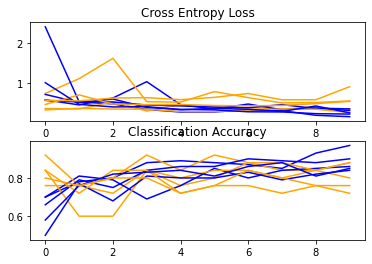

In [52]:
# entry point, run the test harness
run_test_CNN(dataset)

> 78.431
> 86.000
> 90.000
> 82.000
> 84.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


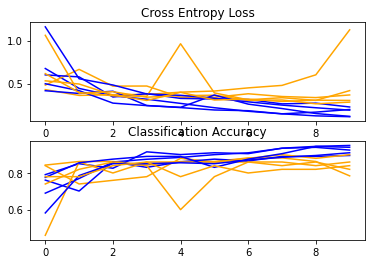

In [53]:
run_test_CNN(dataset,  True)

## GNN Implementation

In [54]:


class GCN(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


def train(model, train_loader, optimizer, criterion):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(model, loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


def run_GNN(dataset, hiddenChannels=64):    
  torch.manual_seed(112358)
  dataset = dataset.shuffle()

  trainLen = int(len(dataset) * 0.66)
  testLen = len(dataset) - trainLen

  train_dataset = dataset[:trainLen]
  test_dataset = dataset[trainLen:]

  print(f'Number of training graphs: {len(train_dataset)}')
  print(f'Number of test graphs: {len(test_dataset)}')

  # Training: 
  # 3 (randomly shuffled) mini-batches, containing all  2⋅64+22=150  graphs.
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



  model = GCN(dataset, hidden_channels=hiddenChannels)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(1, 501):
      train(model, train_loader, optimizer, criterion)
      train_acc = test(model, train_loader)
      test_acc = test(model, test_loader)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



In [55]:
run_GNN(dataset)

Number of training graphs: 124
Number of test graphs: 64
Epoch: 001, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 002, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 003, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 004, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 005, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 006, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 007, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 008, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 009, Train Acc: 0.7177, Test Acc: 0.6094
Epoch: 010, Train Acc: 0.7581, Test Acc: 0.6406
Epoch: 011, Train Acc: 0.7419, Test Acc: 0.6250
Epoch: 012, Train Acc: 0.7823, Test Acc: 0.6875
Epoch: 013, Train Acc: 0.7500, Test Acc: 0.6875
Epoch: 014, Train Acc: 0.7581, Test Acc: 0.6875
Epoch: 015, Train Acc: 0.7742, Test Acc: 0.7188
Epoch: 016, Train Acc: 0.7661, Test Acc: 0.6719
Epoch: 017, Train Acc: 0.7500, Test Acc: 0.7031
Epoch: 018, Train Acc: 0.7742, Test Acc: 0.7031
Epoch: 019, Train Acc: 0.7742, Test Acc: 0.7188
Epoch: 020, Train Acc: 0.7742, 

The CNN recieve better values? Let's instead try with bigger molecules! 

### Mutagenicity Dataset from TU: 

In [56]:
mutagenicity = load_pytorchDataset("Mutagenicity")

Extracting data/TUDataset/Mutagenicity/Mutagenicity.zip
Processing...
Done!

Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_attr=[32, 3], edge_index=[2, 32], x=[16, 14], y=[1])
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


tensor([1])
tensor([0])


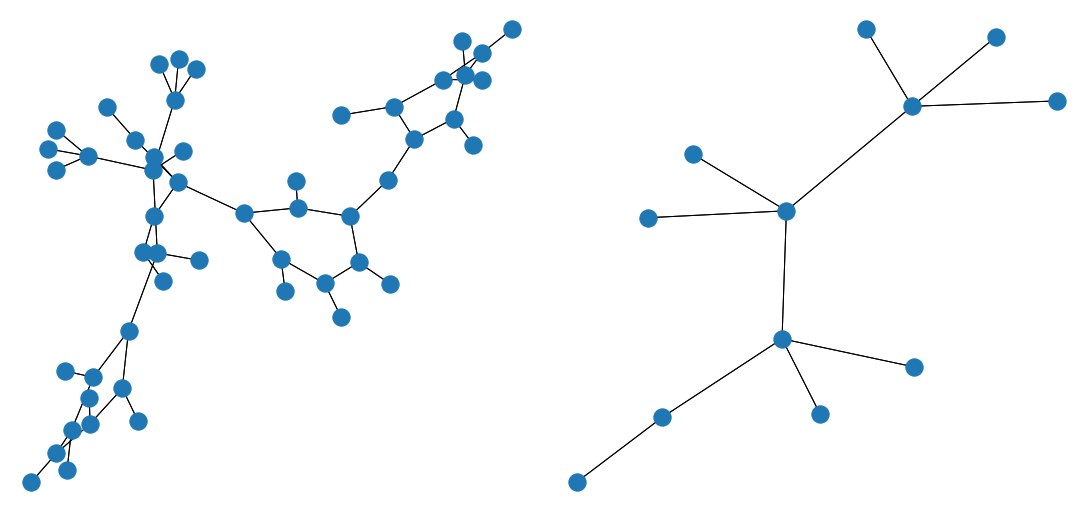

In [67]:
visualizeGraphsFromDataset(mutagenicity, 840, 2300)

In [53]:
#(convertedAdjMatricesAP, groundTruthArrayAP) = convertGraphsToAdjacencyMatrices_autoPad(mutagenicity)  WILL NOT WORK! mutagenicity is waaaaay too big. Will excede RAM allowances and crash. 


In [86]:
shuffledMutagenicity = mutagenicity.shuffle()
truncatedMutagenicity = shuffledMutagenicity[:1000]

In [87]:
(mutexamples, groundTruth) = convertGraphsToAdjacencyMatrices_autoPad(truncatedMutagenicity[:2])

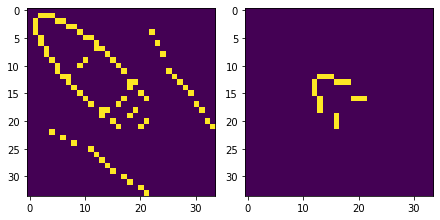

In [88]:
visualizeIsomorphs(mutexamples[0], mutexamples[1])

tensor([0])
tensor([1])


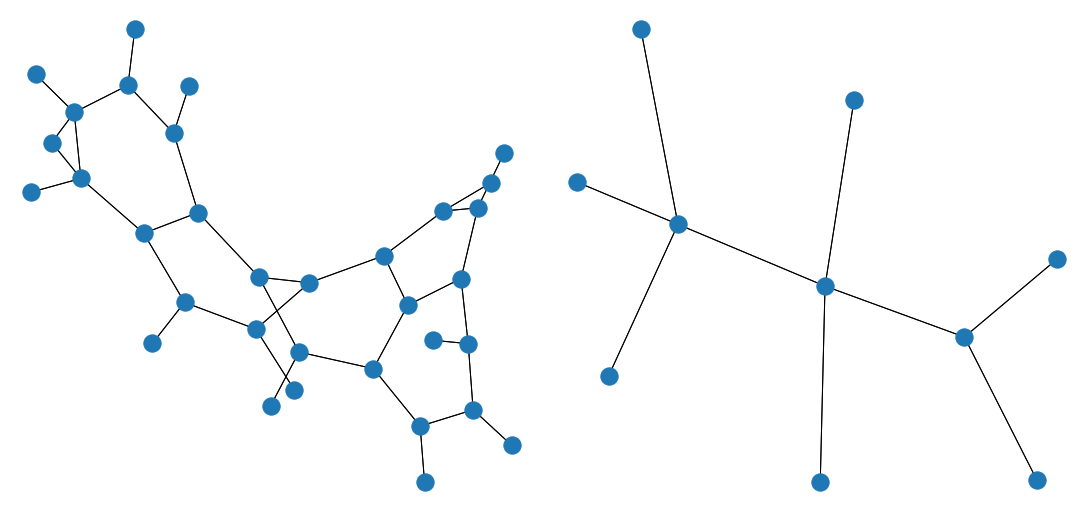

In [89]:
visualizeGraphsFromDataset(truncatedMutagenicity, 0, 1)

### Run CNN on Mutagenicity! 

In [ ]:
run_test_CNN(truncatedMutagenicity)

### Run GNN on Mutagenicity

In [ ]:
run_GNN(truncatedMutagenicity)

In [ ]:
# imdb = load_pytorchDataset("IMDB-BINARY")


Dataset: IMDB-BINARY(1000):
Number of graphs: 1000
Number of features: 0
Number of classes: 2

Data(edge_index=[2, 146], y=[1])
Number of nodes: 20
Number of edges: 146
Average node degree: 7.30
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
# run_test_CNN(imdb)


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_attr=[32, 3], edge_index=[2, 32], x=[16, 14], y=[1])
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
len(shuffledMutagenicity[:1000])
# run_test_CNN(mutagenicity)

1000

> 65.672
> 68.657
> 62.687
> 58.209
> 60.448


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


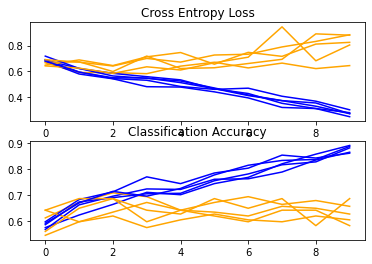

In [ ]:
from torch_geometric.data import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


def train(model, train_loader, optimizer, criterion):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(model, loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.






def run_GNN(dataset, hiddenChannels=64):    
  torch.manual_seed(112358)
  dataset = dataset.shuffle()

  trainLen = int(len(dataset) * 0.66)
  testLen = len(dataset) - trainLen

  train_dataset = dataset[:trainLen]
  test_dataset = dataset[trainLen:]

  print(f'Number of training graphs: {len(train_dataset)}')
  print(f'Number of test graphs: {len(test_dataset)}')

  # Training: 
  # 3 (randomly shuffled) mini-batches, containing all  2⋅64+22=150  graphs.
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



  model = GCN(dataset, hidden_channels=hiddenChannels)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(1, 501):
      train(model, train_loader, optimizer, criterion)
      train_acc = test(model, train_loader)
      test_acc = test(model, test_loader)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')





In [ ]:
run_GNN(dataset)

Number of training graphs: 124
Number of test graphs: 64
Epoch: 001, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 002, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 003, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 004, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 005, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 006, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 007, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 008, Train Acc: 0.7016, Test Acc: 0.5938
Epoch: 009, Train Acc: 0.7177, Test Acc: 0.6094
Epoch: 010, Train Acc: 0.7581, Test Acc: 0.6406
Epoch: 011, Train Acc: 0.7419, Test Acc: 0.6250
Epoch: 012, Train Acc: 0.7823, Test Acc: 0.6875
Epoch: 013, Train Acc: 0.7500, Test Acc: 0.6875
Epoch: 014, Train Acc: 0.7581, Test Acc: 0.6875
Epoch: 015, Train Acc: 0.7742, Test Acc: 0.7188
Epoch: 016, Train Acc: 0.7661, Test Acc: 0.6719
Epoch: 017, Train Acc: 0.7500, Test Acc: 0.7031
Epoch: 018, Train Acc: 0.7742, Test Acc: 0.7031
Epoch: 019, Train Acc: 0.7742, Test Acc: 0.7188
Epoch: 020, Train Acc: 0.7742, 

In [ ]:
# run_GNN(imdb, imdb.)

Number of training graphs: 200
Number of test graphs: 900


AttributeError: ignored

Extracting data/TUDataset/Mutagenicity/Mutagenicity.zip
Processing...
Done!

Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_attr=[32, 3], edge_index=[2, 32], x=[16, 14], y=[1])
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
# Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])

# DBLP_v1[0]
run_GNN(mutagenicity)

Number of training graphs: 2862
Number of test graphs: 1475
Epoch: 001, Train Acc: 0.7068, Test Acc: 0.7024
Epoch: 002, Train Acc: 0.7124, Test Acc: 0.7064
Epoch: 003, Train Acc: 0.7149, Test Acc: 0.7085
Epoch: 004, Train Acc: 0.7358, Test Acc: 0.7369
Epoch: 005, Train Acc: 0.7484, Test Acc: 0.7268
Epoch: 006, Train Acc: 0.7530, Test Acc: 0.7478
Epoch: 007, Train Acc: 0.7446, Test Acc: 0.7227
Epoch: 008, Train Acc: 0.7704, Test Acc: 0.7417
Epoch: 009, Train Acc: 0.7467, Test Acc: 0.7308
Epoch: 010, Train Acc: 0.7673, Test Acc: 0.7410
Epoch: 011, Train Acc: 0.7652, Test Acc: 0.7444
Epoch: 012, Train Acc: 0.7481, Test Acc: 0.7193
Epoch: 013, Train Acc: 0.7610, Test Acc: 0.7410
Epoch: 014, Train Acc: 0.7435, Test Acc: 0.7112
Epoch: 015, Train Acc: 0.7498, Test Acc: 0.7295
Epoch: 016, Train Acc: 0.7718, Test Acc: 0.7485
Epoch: 017, Train Acc: 0.7732, Test Acc: 0.7451
Epoch: 018, Train Acc: 0.7582, Test Acc: 0.7281
Epoch: 019, Train Acc: 0.7788, Test Acc: 0.7492
Epoch: 020, Train Acc: 0.768